In [1]:
import sys
import json
import pickle
from tqdm import tqdm
from pathlib import Path
import random

import torch
import numpy as np
import pandas as pd

from scipy.special import softmax

import pyro.distributions as dist

sys.path.append("/home/mind/jrobador/pavi_pytorch/")
from utils.dataset import HCPDataLoader, HCPDataset
from utils.config import PATH_TEMPLATE_FULL, SUBJECTS_LIST
from utils.downstream import ScoresPredictionTask

# DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device('cpu')
PATH_CAMCAN_DATA = Path("/home/mind/alebris/projects/pavi_project/experiments_parcellation/5_camcan_bis/subjects_difumo_128.pkl")

/home/mind/jrobador/.local/miniconda3/envs/pavi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


# Generate the jobs

In [2]:
with open(PATH_CAMCAN_DATA, 'rb') as f:
    xr_data = pickle.load(f)

In [3]:
list_subjects = xr_data.Subject.values

In [4]:
sub_list = []
seed = []
for k in [48, 96, 144, 192, 240]:
    for i in range(10):
        sub_list.append(random.sample(list(list_subjects), k=k))
        seed.append(42)

In [17]:
# json_file = json.dumps({'sub_list': sub_list, 'seed': seed})

# with open('jobs.json', 'w') as f:
#     f.write(json_file)

# Test CamCAN scores

In [5]:
with open(PATH_CAMCAN_DATA, 'rb') as f:
    xr_data = pickle.load(f)

In [6]:
df_scores = pd.read_csv('neuropsych_scores.csv', index_col=0)
df_scores.reset_index(names='Subject').to_csv('scores_camcan.csv')
mask_scores = df_scores.loc[xr_data.Subject].isna().sum(0) < 30
df_scores_post = df_scores.loc[xr_data.Subject][df_scores.columns[mask_scores]]
df_scores_post.reset_index(names='Subject').to_csv('scores_camcan_2.csv')

In [7]:
categories = [
    'BentonFaces_total',
    'Cattell_total',
    'EkmanEmHex_pca1',
    'FamousFaces_details',
    'Hotel_time',
    'PicturePriming_baseline_acc',
    'Proverbs',
    'Synsem_prop_error',
    'Synsem_RT',
    'VSTMcolour_K_mean',
    'VSTMcolour_K_precision',
    'VSTMcolour_K_doubt',
    'VSTMcolour_MSE'
]

In [8]:
fancy_categories = [
    'Benton faces',
    'Fluid Intelligence',
    'Emotion expression recognition',
    'Famous faces',
    'Hotel task',
    'Picture priming',
    'Proverb comprehension',
    'Sentence comprehension (unacceptable error)',
    'Sentence comprehension (reaction time)',
    'Visual short term memory (mean)',
    'Visual short term memory (precision)',
    'Visual short term memory (doubt)',
    'Visual short term memory (MSE)',
]

In [9]:
with open('jobs.json', 'rb') as f:
    jobs = json.load(f)

In [10]:
subjects_list = jobs['sub_list'][1]

In [11]:
sp_task = ScoresPredictionTask(
    path_run='.',
    path_scores='scores_camcan.csv',
    categories=categories,
    fancy_categories_names=fancy_categories,
    subjects=subjects_list
)

# Explore samples

In [13]:
# Load sample
# sample_dir = Path('./runs/inference_S553_XR/checkpoints/12_mean_sample_post.pt')
# sample = torch.load(sample_dir, map_location='cpu')

state_dir = Path('/home/mind/alebris/projects/pavi_project/experiments_parcellation/3_camcan/runs_warmbayes/transfer_learning_40_S240/checkpoints/12_state.pt')
state = torch.load(state_dir, map_location='cpu')

In [21]:

state['guide'].keys()



odict_keys(['encodings.plate_S_unconstrained', 'encodings.plate_S_plate_T_unconstrained', 'encodings.plate_N_unconstrained', 'encodings.plate_N_plate_S_unconstrained', 'mu_g.0_transform.loc_unconstrained', 'mu_g.0_transform.diag_scale_unconstrained', 'epsilon.0_transform.loc_unconstrained', 'epsilon.0_transform.diag_scale_unconstrained', 'sigma.0_transform.loc_unconstrained', 'sigma.0_transform.diag_scale_unconstrained', 'kappa.0_transform.loc_unconstrained', 'kappa.0_transform.diag_scale_unconstrained', 'gamma.0_transform.loc_unconstrained', 'gamma.0_transform.diag_scale_unconstrained', 'mu_s.0_transform.loc_nn.layers.0.weight', 'mu_s.0_transform.loc_nn.layers.0.bias', 'mu_s.0_transform.loc_nn.layers.1.weight', 'mu_s.0_transform.loc_nn.layers.1.bias', 'mu_s.0_transform.loc_nn.layers.2.weight', 'mu_s.0_transform.loc_nn.layers.2.bias', 'mu_s.0_transform.scale_nn.layers.0.weight', 'mu_s.0_transform.scale_nn.layers.0.bias', 'mu_s.0_transform.scale_nn.layers.1.weight', 'mu_s.0_transform.sc

In [27]:
state['guide']['encodings.plate_S_unconstrained'].shape

torch.Size([240, 1, 1, 48])

In [8]:
sample['theta_s'].reshape(-1, 17).std(0)

tensor([0.8120, 0.6657, 1.0926, 0.6823, 0.9543, 0.8400, 0.8471, 0.9880, 0.4861,
        0.5439, 0.3230, 0.7901, 0.7560, 0.4748, 0.7868, 0.5587, 0.9390])

In [7]:
sample['gamma']

tensor([0.7834, 0.6366, 1.2154, 0.6973, 0.8151, 0.8589, 0.7455, 0.8462, 0.7045,
        0.6437, 0.3889, 0.7083, 0.7966, 0.5579, 0.9013, 0.5664, 0.9867])

In [8]:
sample['gamma']

tensor([0.0951, 0.1149, 0.1129, 0.0817, 0.0820, 0.5335, 0.2136, 0.6033, 0.2695,
        0.1283, 0.1551, 0.1397, 0.0930, 0.1366, 0.1073, 0.8567, 0.5010])

In [ ]:
sample['mu_s'].mean(0)

tensor([[0.0511, 0.0487, 0.0212,  ..., 0.0310, 0.0190, 0.1083],
        [0.0070, 0.0103, 0.0222,  ..., 0.0350, 0.0304, 0.0134],
        [0.0140, 0.1535, 0.0285,  ..., 0.0246, 0.0271, 0.0409],
        ...,
        [0.0100, 0.0311, 0.0281,  ..., 0.0065, 0.0219, 0.0276],
        [0.1466, 0.0505, 0.0080,  ..., 0.0189, 0.0150, 0.0372],
        [0.0364, 0.0548, 0.0467,  ..., 0.0121, 0.0141, 0.0641]])

In [ ]:
sample['mu_g']

tensor([[ 0.0529,  0.0504,  0.0177,  ...,  0.0385,  0.0114,  0.1080],
        [ 0.0097,  0.0137,  0.0428,  ...,  0.0481,  0.0254,  0.0115],
        [ 0.0048,  0.1623,  0.0269,  ...,  0.0265,  0.0331,  0.0256],
        ...,
        [ 0.0172,  0.0444,  0.0425,  ..., -0.0018,  0.0281,  0.0291],
        [ 0.1518,  0.0439, -0.0002,  ...,  0.0285,  0.0238,  0.0489],
        [ 0.0305,  0.0601,  0.0298,  ...,  0.0261,  0.0136,  0.0838]])

In [ ]:
sample['epsilon']

tensor([[0.0691, 0.0688, 0.0692,  ..., 0.0660, 0.0591, 0.0732],
        [0.0621, 0.0644, 0.0607,  ..., 0.0694, 0.0593, 0.0716],
        [0.0742, 0.0643, 0.0511,  ..., 0.0724, 0.0695, 0.0633],
        ...,
        [0.0730, 0.0663, 0.0643,  ..., 0.0714, 0.0665, 0.0633],
        [0.0585, 0.0634, 0.0712,  ..., 0.0618, 0.0660, 0.0648],
        [0.0636, 0.0645, 0.0678,  ..., 0.0676, 0.0641, 0.0588]])

In [ ]:
sample['mu_st'][0]

tensor([[[ 0.0958,  0.0164,  0.0259,  ...,  0.0974,  0.0270,  0.0640],
         [ 0.0137,  0.1379,  0.0111,  ...,  0.0574,  0.0296,  0.0530],
         [ 0.1337,  0.0305,  0.0047,  ...,  0.0383,  0.0220,  0.0363],
         ...,
         [ 0.0420,  0.0789,  0.0277,  ...,  0.1082,  0.0333,  0.0718],
         [ 0.0073,  0.0085,  0.0339,  ...,  0.0196,  0.0092,  0.0158],
         [-0.0005,  0.0211,  0.1305,  ...,  0.0104,  0.0166,  0.0232]],

        [[ 0.0960,  0.0161,  0.0260,  ...,  0.0974,  0.0262,  0.0641],
         [ 0.0135,  0.1367,  0.0110,  ...,  0.0577,  0.0296,  0.0533],
         [ 0.1355,  0.0306,  0.0041,  ...,  0.0379,  0.0228,  0.0361],
         ...,
         [ 0.0425,  0.0774,  0.0292,  ...,  0.1094,  0.0323,  0.0708],
         [ 0.0071,  0.0091,  0.0345,  ...,  0.0195,  0.0087,  0.0154],
         [-0.0003,  0.0209,  0.1307,  ...,  0.0105,  0.0171,  0.0230]]])

In [ ]:
sample['mu_s'][0]

tensor([[0.0948, 0.0161, 0.0274,  ..., 0.0999, 0.0255, 0.0602],
        [0.0161, 0.1380, 0.0159,  ..., 0.0571, 0.0255, 0.0498],
        [0.1214, 0.0316, 0.0034,  ..., 0.0257, 0.0265, 0.0357],
        ...,
        [0.0464, 0.0812, 0.0307,  ..., 0.1158, 0.0336, 0.0757],
        [0.0051, 0.0082, 0.0296,  ..., 0.0271, 0.0111, 0.0227],
        [0.0042, 0.0157, 0.1230,  ..., 0.0093, 0.0207, 0.0233]])

In [ ]:
sample['mu_st'][0].mean(0)

tensor([[ 0.0959,  0.0162,  0.0260,  ...,  0.0974,  0.0266,  0.0641],
        [ 0.0136,  0.1373,  0.0110,  ...,  0.0576,  0.0296,  0.0532],
        [ 0.1346,  0.0306,  0.0044,  ...,  0.0381,  0.0224,  0.0362],
        ...,
        [ 0.0423,  0.0781,  0.0285,  ...,  0.1088,  0.0328,  0.0713],
        [ 0.0072,  0.0088,  0.0342,  ...,  0.0196,  0.0090,  0.0156],
        [-0.0004,  0.0210,  0.1306,  ...,  0.0105,  0.0168,  0.0231]])

In [ ]:
sample['mu_s'][0]

tensor([[0.0948, 0.0161, 0.0274,  ..., 0.0999, 0.0255, 0.0602],
        [0.0161, 0.1380, 0.0159,  ..., 0.0571, 0.0255, 0.0498],
        [0.1214, 0.0316, 0.0034,  ..., 0.0257, 0.0265, 0.0357],
        ...,
        [0.0464, 0.0812, 0.0307,  ..., 0.1158, 0.0336, 0.0757],
        [0.0051, 0.0082, 0.0296,  ..., 0.0271, 0.0111, 0.0227],
        [0.0042, 0.0157, 0.1230,  ..., 0.0093, 0.0207, 0.0233]])

In [ ]:
sample['sigma'].max(-1)

torch.return_types.max(
values=tensor([0.0328, 0.0466, 0.0345, 0.0468, 0.0426, 0.0462, 0.1985, 0.0173, 0.0350,
        0.0351, 0.2047, 0.0373, 0.0356, 0.0505, 0.0387, 0.0365, 0.0458]),
indices=tensor([ 32,  75,  58,  38,  28,  82,  79, 125,  36,  77,  91,  13,  41, 124,
         36,  35,  16]))

In [ ]:
sample['epsilon'][3].max()

tensor(0.0057)

In [ ]:
(sample['sigma'] ** -1).mean(-1)

tensor([113.5662,  95.5378,  86.1161,  78.7148,  94.1634, 128.7284,   5.2598,
        195.7948, 100.0517,  76.5019,   5.2493,  97.0262, 101.0987,  78.3395,
        114.4301, 129.3518, 100.2153])

In [ ]:
state['guide']['mu_g.0_transform.diag_scale_unconstrained']

tensor([-8.7900, -8.8558, -9.2683,  ..., -9.3947, -9.5232, -8.9816])

In [ ]:
for p in state['guide'].keys():
    print(p)

encodings.plate_S_unconstrained
encodings.plate_S_plate_T_unconstrained
encodings.plate_N_unconstrained
encodings.theta_s_plate_N_unconstrained
encodings.theta_s_plate_S_unconstrained
mu_g.0_transform.loc_unconstrained
mu_g.0_transform.diag_scale_unconstrained
epsilon.0_transform.loc_unconstrained
epsilon.0_transform.diag_scale_unconstrained
sigma.0_transform.loc_unconstrained
sigma.0_transform.diag_scale_unconstrained
kappa.0_transform.loc_unconstrained
kappa.0_transform.diag_scale_unconstrained
gamma.0_transform.loc_unconstrained
gamma.0_transform.diag_scale_unconstrained
mu_s.0_transform.loc_nn.layers.0.weight
mu_s.0_transform.loc_nn.layers.0.bias
mu_s.0_transform.loc_nn.layers.1.weight
mu_s.0_transform.loc_nn.layers.1.bias
mu_s.0_transform.loc_nn.layers.2.weight
mu_s.0_transform.loc_nn.layers.2.bias
mu_s.0_transform.scale_nn.layers.0.weight
mu_s.0_transform.scale_nn.layers.0.bias
mu_s.0_transform.scale_nn.layers.1.weight
mu_s.0_transform.scale_nn.layers.1.bias
mu_s.0_transform.scal

In [ ]:
sample['sigma']

tensor([[0.0177, 0.0180, 0.0090,  ..., 0.0088, 0.0053, 0.0172],
        [0.0093, 0.0151, 0.0248,  ..., 0.0052, 0.0094, 0.0195],
        [0.0084, 0.0191, 0.0158,  ..., 0.0144, 0.0076, 0.0144],
        ...,
        [0.0165, 0.0237, 0.0341,  ..., 0.0054, 0.0088, 0.0266],
        [0.0186, 0.0290, 0.0032,  ..., 0.0197, 0.0066, 0.0243],
        [0.0044, 0.0116, 0.0079,  ..., 0.0093, 0.0061, 0.0205]])

In [ ]:
((sample['theta_s'] - sample['theta'][None, ...]) ** 2).mean(0) ** 0.5

tensor([[0.2065, 0.2405, 0.2559,  ..., 0.2129, 0.2388, 0.2252],
        [0.2179, 0.2470, 0.2105,  ..., 0.2374, 0.3044, 0.2612],
        [0.2784, 0.2501, 0.2833,  ..., 0.2097, 0.5319, 0.2729],
        ...,
        [0.2056, 0.2458, 0.2441,  ..., 0.2360, 0.2499, 0.2605],
        [0.2265, 0.2608, 0.2464,  ..., 0.2109, 0.2517, 0.2136],
        [0.2207, 0.2446, 0.2293,  ..., 0.2284, 0.2357, 0.2346]])

In [ ]:
sigma_q = sample['gamma']
sigma_p = sample['theta_s'].std(0).mean(0)

In [ ]:
sigma_p / sigma_q + np.log(sigma_q / sigma_p) - 1 

tensor([0.4589, 0.4714, 0.4738, 0.4699, 0.4769, 0.4697, 0.4713, 0.4661, 0.4726,
        0.4691, 0.4759, 0.4715, 0.4667, 0.4739, 0.4707, 0.4617, 0.4701])

In [ ]:
(((sample['theta_s'] - sample['theta'][None, ...]) ** 2) / sigma_q).mean()

tensor(0.1010)

In [ ]:
sample['theta_s'].reshape(-1, 17).std(0)

tensor([1.1527, 1.0651, 0.5804, 1.1971, 0.7507, 1.0972, 1.2106, 0.9524, 0.7477,
        1.0306, 0.9675, 0.8575, 0.7148, 0.9464, 0.9189, 1.4435, 0.9912])

In [ ]:
sample['theta_s'][0, 100]

tensor([-0.6915,  1.1421,  1.9844,  0.0735,  0.9909, -0.4243, -0.9687,  0.0348,
         1.4003, -0.9058,  0.7777, -0.0864,  0.5931,  1.9426, -0.1369, -2.0746,
         2.0473])

In [ ]:
sample['theta_s'][10, 100]

tensor([-0.7479,  1.5876,  1.9601,  0.2930,  0.9521, -0.0560, -1.2373,  0.0815,
         1.7146, -1.1850,  0.9790, -0.3710,  0.6170,  1.8795, -0.5727, -2.0635,
         2.2181])

In [ ]:
prior = dist.Normal(sample['theta'], sample['gamma']).to_event(1)
prior_logprob = prior.log_prob(sample['theta_s'])

In [ ]:
posterior = dist.Normal(sample['theta_s'].mean(0), sample['theta_s'].std(0)).to_event(1)
posterior_logprob = posterior.log_prob(sample['theta_s'])

In [ ]:
kl_div = (posterior_logprob - prior_logprob).sum() / posterior_logprob.numel()

In [ ]:
kl_div

tensor(12.1567)

In [ ]:
from scipy.special import softmax
temp = softmax(sample['theta'][20305])
- (temp * np.log(temp)).sum() / np.log(17)

0.9902999588812669

In [ ]:
for p in state['guide']:
    print(p)

encodings.mu_s_plate_S_unconstrained
encodings.theta_plate_N_unconstrained
encodings.gamma_plate_N_unconstrained
encodings.theta_s_plate_N_unconstrained
encodings.theta_s_plate_S_unconstrained
mu_g.0_transform.loc_unconstrained
mu_g.0_transform.diag_scale_unconstrained
epsilon.0_transform.loc_unconstrained
epsilon.0_transform.diag_scale_unconstrained
gamma.0_transform.loc_unconstrained
gamma.0_transform.diag_scale_unconstrained
kappa.0_transform.loc_unconstrained
kappa.0_transform.diag_scale_unconstrained
mu_s.0_transform.loc_nn.layers.0.weight
mu_s.0_transform.loc_nn.layers.0.bias
mu_s.0_transform.loc_nn.layers.1.weight
mu_s.0_transform.loc_nn.layers.1.bias
mu_s.0_transform.loc_nn.layers.2.weight
mu_s.0_transform.loc_nn.layers.2.bias
mu_s.0_transform.scale_nn.layers.0.weight
mu_s.0_transform.scale_nn.layers.0.bias
mu_s.0_transform.scale_nn.layers.1.weight
mu_s.0_transform.scale_nn.layers.1.bias
mu_s.0_transform.scale_nn.layers.2.weight
mu_s.0_transform.scale_nn.layers.2.bias
theta_s.0

In [ ]:
state['guide']['gamma.0_transform.loc_unconstrained']

tensor([-0.4502, -0.5197, -0.4493, -0.4849, -0.4819, -0.4217, -0.4518, -0.4791,
        -0.4511, -0.4809, -0.5053, -0.5033, -0.5320, -0.5725, -0.5210, -0.5101,
        -0.4395])

In [ ]:
state['guide']['encodings.theta_s_plate_N_unconstrained'].std(0)

tensor([1.1043, 1.1163, 1.1026, 1.1890, 1.1378, 1.0132, 1.1038, 1.1308])

In [ ]:
state['guide']['encodings.mu_s_plate_S_unconstrained'].std(0)

tensor([0.1788, 0.1812, 0.1779, 0.1800, 0.1757, 0.1775, 0.1753, 0.1765, 0.1799,
        0.1790, 0.1838, 0.1775, 0.1792, 0.1795, 0.1870, 0.1823, 0.1760, 0.1823,
        0.1796, 0.1794, 0.1703, 0.1739, 0.1734, 0.1829])

# Test Dataloader

In [ ]:
n_subjects = 350
cards_full = {"plate_S": n_subjects, "plate_T": 2, "plate_N": 59_412}
cards_reduced = {"plate_S": 8, "plate_T": 2, "plate_N": 2_048}
num_difumo = 128
num_labels = 17

In [ ]:
PATH_TEMPLATE_FULL_WORK = '/gpfswork/rech/hjt/utd91af/data/hcp_pearsons_coeffs_difumo/%s_T%d_difumo%d_preproc_pearsons_coeffs_full.npy'

In [ ]:
dataset = HCPDataset(
    full_cards=cards_full,
    reduced_cards=cards_reduced,
    num_difumo_components=num_difumo,
    path_template=PATH_TEMPLATE_FULL,
    drop_last=False,
    ignore_plate_t=False,
    normalize_inputs=True,
    quantile_top_corr=0.8,
)

/gpfsdswork/projects/rech/hjt/utd91af/pavi_project/experiments/5_learning_curves_model_G_norm/../utils/dataset.py:65: UserWarning: Wrong number of subjects between `num_subjects` and `subject_list`.Only the firsts in the list are selected
  warnings.warn(


In [ ]:
dataloader = HCPDataLoader(
    dataset,
    num_workers=2,
    prefetch_factor=4,
    # pin_memory=True
)

In [ ]:
data, idx = next(iter(dataloader))

In [ ]:
data.shape

torch.Size([8, 2, 2048, 128])

In [ ]:
for _ in tqdm(range(10)):
    data, idx = next(iter(dataloader))

100%|██████████| 10/10 [01:18<00:00,  7.86s/it]


# Test guide

In [2]:
n_job = 30
    
with open('jobs.json', 'r') as f:
    jobs = json.load(f)

subjects_idx = jobs['sub_list'][n_job]
subjects_list = SUBJECTS_LIST[subjects_idx]
n_subjects = len(subjects_list)

In [3]:
from script_hcp import main as import_module

path_run = Path('runs') / 'inference_30_S384_HCP_baseline_2'

inference_module = import_module(
    subjects_list=subjects_list,
    num_iter=42,
    load_state=path_run / 'checkpoints' / '12_state.pt',
    return_inference_module=True,
    device=DEVICE
)

In [34]:
cards_full = {"plate_S": n_subjects, "plate_T": 4, "plate_N": 59_412}
cards_reduced = {"plate_S": 16, "plate_T": 2, "plate_N": 1024}
num_difumo = 128
num_labels = 17

dataset = HCPDataset(
    full_cards=cards_full,
    reduced_cards=cards_reduced,
    num_difumo_components=num_difumo,
    subject_list=subjects_list,
    path_template=PATH_TEMPLATE_FULL,
    drop_last=False,
    ignore_plate_t=True,
    group_LR_RL_scans=True,
    normalize_inputs=True,
    quantile_top_corr=0.8,
)

dataloader = HCPDataLoader(
    dataset,
    num_workers=2,
    # pin_memory=True
)

In [9]:
data, idx = next(iter(dataloader))

In [10]:
idx

{'plate_S': tensor([279, 312, 353, 280, 168,  18,  41,  14,  23, 379, 183, 184, 116, 307,
         123, 219, 279, 312, 353, 280, 168,  18,  41,  14,  23, 379, 183, 184,
         116, 307, 123, 219]),
 'plate_T': tensor([0, 1]),
 'plate_N': tensor([ 8061, 13081, 28786,  ..., 16675, 22857, 32011])}

In [35]:
trace_model, trace_guide = inference_module.elbo._get_trace(
    inference_module.model,
    inference_module.guide,
    args=(),
    kwargs={
        'data': data,
        'idx': idx
    }
)

/home/mind/alebris/storage/miniconda/envs/pavi_project/lib/python3.10/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'l_s'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


In [ ]:
def mean_sigma(values, dim=None):
    return (values ** -2).mean(dim) ** -0.5

tensor([0.0162, 0.0154, 0.0169, 0.0171, 0.0158, 0.0159, 0.0157, 0.0166, 0.0171,
        0.0154, 0.0174, 0.0161, 0.0170, 0.0161, 0.0179, 0.0162, 0.0160],
       grad_fn=<PowBackward0>)

In [ ]:
mean_sigma(trace_guide.nodes['sigma']['value'], dim=-1)

NameError: name 'mean_sigma' is not defined

In [12]:
trace_guide.nodes['sigma']['fn'].transforms[1].loc.exp()

KeyError: 'sigma'

In [36]:
trace_guide.nodes['epsilon']['fn'].transforms[1].loc.exp()

tensor([0.0053, 0.0153, 0.0338,  ..., 0.0208, 0.0183, 0.0227],
       grad_fn=<ExpBackward0>)

In [43]:
trace_guide.nodes['kappa']['value']

tensor([0.0624], grad_fn=<AddBackward0>)

In [44]:
trace_guide.nodes['mu_g']['fn'].transforms[1].scale

tensor([0.0003, 0.0007, 0.0012,  ..., 0.0011, 0.0009, 0.0010],
       grad_fn=<AddBackward0>)

In [45]:
trace_guide.nodes['mu_g']['fn'].transforms[1].loc

Parameter containing:
tensor([0.0046, 0.0235, 0.1782,  ..., 0.0478, 0.0327, 0.0456],
       requires_grad=True)

In [46]:
trace_guide.nodes['mu_s']['fn'].transforms[1].loc.mean(0)

tensor([[0.0068, 0.0291, 0.1686,  ..., 0.0441, 0.0241, 0.0418]],
       grad_fn=<MeanBackward1>)

In [47]:
trace_guide.nodes['mu_s']['fn'].transforms[1].loc.std(0)

tensor([[0.0064, 0.0118, 0.0469,  ..., 0.0190, 0.0088, 0.0224]],
       grad_fn=<StdBackward0>)

In [48]:
trace_guide.nodes['mu_s']['fn'].transforms[1].scale[0]

tensor([[0.0008, 0.0009, 0.0007,  ..., 0.0009, 0.0012, 0.0011]],
       grad_fn=<SelectBackward0>)

In [49]:
trace_guide.nodes['mu_s']['fn'].transforms[1].loc

tensor([[[ 7.6992e-03,  3.0312e-02,  1.8089e-01,  ...,  4.8882e-02,
           3.4654e-02,  7.3219e-02]],

        [[ 1.4260e-02,  3.4217e-02,  1.7596e-01,  ...,  6.1506e-02,
           2.3735e-02,  2.9507e-02]],

        [[ 8.3715e-04,  5.6318e-02,  3.1182e-02,  ...,  4.2323e-02,
           1.0397e-02,  7.1201e-02]],

        ...,

        [[ 1.8587e-02,  2.0930e-02,  2.0296e-01,  ...,  2.0165e-02,
           2.7961e-02, -1.1353e-02]],

        [[ 4.3398e-03,  3.6509e-02,  1.9748e-01,  ...,  5.0368e-02,
           2.2863e-02,  3.4644e-02]],

        [[ 1.4260e-05,  3.9250e-02,  1.8747e-01,  ...,  4.5870e-02,
           1.7114e-02,  7.6771e-02]]], grad_fn=<ReshapeAliasBackward0>)

In [50]:
trace_guide.nodes['mu_st']['fn'].transforms[1].loc.mean(1)

KeyError: 'mu_st'

In [19]:
trace_guide.nodes['mu_st']['fn'].transforms[1].loc[0]

tensor([[[ 0.0133,  0.0413,  0.1307,  ..., -0.0064, -0.0115, -0.0011]],

        [[ 0.0114,  0.0677,  0.1273,  ..., -0.0058, -0.0109, -0.0009]],

        [[ 0.0150,  0.0548,  0.1129,  ..., -0.0063, -0.0112, -0.0010]],

        [[ 0.0043,  0.0616,  0.1513,  ..., -0.0061, -0.0108, -0.0010]]],
       grad_fn=<SelectBackward0>)

In [27]:
trace_guide.nodes['mu_st']['fn'].transforms[1].scale[10][0,0].reshape(17, 128)

tensor([[0.0005, 0.0005, 0.0005,  ..., 0.0005, 0.0006, 0.0005],
        [0.0005, 0.0005, 0.0005,  ..., 0.0004, 0.0004, 0.0005],
        [0.1482, 0.1475, 0.1509,  ..., 0.1502, 0.1461, 0.1465],
        ...,
        [0.1408, 0.1480, 0.1443,  ..., 0.1449, 0.1525, 0.1461],
        [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
        [0.1438, 0.1514, 0.1510,  ..., 0.1452, 0.1460, 0.1466]],
       grad_fn=<ReshapeAliasBackward0>)

In [29]:
trace_guide.nodes['sigma']['fn'].transforms[1].loc.exp()

tensor([0.0071, 0.0248, 0.0327,  ..., 0.1455, 0.1476, 0.1480],
       grad_fn=<ExpBackward0>)

In [31]:
trace_guide.nodes['epsilon']['fn'].transforms[1].loc.exp()

tensor([0.0015, 0.0035, 0.0041,  ..., 0.0103, 0.0101, 0.0103],
       grad_fn=<ExpBackward0>)

In [51]:
trace_guide.nodes['gamma']['fn'].transforms[0].loc.exp()

tensor([0.8526, 0.6784, 0.7010, 0.5337, 0.5388, 0.5191, 0.7130, 0.5056, 0.4753,
        0.5754, 0.5778, 0.6049, 0.5654, 0.5695, 0.5184, 0.8683, 0.4750],
       grad_fn=<ExpBackward0>)

In [52]:
trace_guide.nodes['theta_s']['fn'].transforms[0].loc

tensor([[[-0.3335,  0.4970, -0.1471,  ...,  0.2502,  0.7069, -0.0683],
         [-0.0848,  0.4006, -0.1122,  ...,  0.2883, -0.0568,  0.0760],
         [ 0.3582,  0.7292, -0.0465,  ...,  0.0355,  0.4636, -0.0631],
         ...,
         [ 0.3480,  0.6200, -0.1223,  ..., -0.1201, -0.0553,  0.0825],
         [ 0.2115,  1.1319, -0.3273,  ...,  0.0699,  0.8254, -0.0388],
         [-0.2316,  0.6067, -0.2823,  ...,  0.5156,  0.3770,  0.0612]],

        [[-0.5464,  0.2485,  0.0835,  ...,  0.2151,  0.7757, -0.2111],
         [-0.3213,  0.1794,  0.1856,  ...,  0.2652,  0.0129, -0.0275],
         [ 0.1202,  0.4752,  0.2766,  ...,  0.0249,  0.4812, -0.1850],
         ...,
         [ 0.0868,  0.3651,  0.1229,  ..., -0.1200, -0.0215,  0.0090],
         [ 0.0205,  0.8699, -0.1160,  ...,  0.0697,  0.8326, -0.1380],
         [-0.4974,  0.3845,  0.0264,  ...,  0.4583,  0.3622, -0.0550]],

        [[-0.5265,  0.3651,  0.0366,  ..., -0.0722,  0.8255, -0.3573],
         [-0.4335,  0.2303,  0.0902,  ...,  0

In [53]:
trace_guide.nodes['theta_s']['fn'].transforms[0].loc.mean(0)

tensor([[-0.2013,  0.1224,  0.0180,  ...,  0.1247,  0.5626, -0.2641],
        [ 0.0182,  0.0458,  0.0939,  ...,  0.1688, -0.1580, -0.1181],
        [ 0.4885,  0.3544,  0.1819,  ..., -0.0763,  0.3252, -0.2487],
        ...,
        [ 0.4812,  0.2425,  0.0679,  ..., -0.2393, -0.1682, -0.0553],
        [ 0.4098,  0.7145, -0.1954,  ..., -0.0532,  0.7051, -0.2222],
        [-0.1343,  0.2440, -0.0953,  ...,  0.3433,  0.2206, -0.1335]],
       grad_fn=<MeanBackward1>)

In [54]:
trace_guide.nodes['theta']['fn'].transforms[0].loc

tensor([[ 0.0790,  0.2384, -0.1549,  ...,  0.1251,  0.3098, -0.1520],
        [ 0.0243,  0.2357, -0.1565,  ...,  0.1103,  0.3077, -0.1415],
        [ 0.0530,  0.2491, -0.1219,  ...,  0.0750,  0.3266, -0.1518],
        ...,
        [ 0.1010,  0.2560, -0.1078,  ...,  0.0716,  0.3352, -0.1628],
        [ 0.1259,  0.2611, -0.0962,  ...,  0.0644,  0.3419, -0.1692],
        [ 0.1992,  0.2798, -0.0518,  ...,  0.0301,  0.3670, -0.1893]],
       grad_fn=<ReshapeAliasBackward0>)

In [59]:
trace_guide.nodes['theta_s']['fn'].transforms[0].loc.reshape(-1, 17).std(0)

tensor([0.5022, 0.3714, 0.3152, 0.3127, 0.2922, 0.3021, 0.3217, 0.3351, 0.1550,
        0.3215, 0.2394, 0.2668, 0.2757, 0.3236, 0.2784, 0.4425, 0.2008],
       grad_fn=<StdBackward0>)

In [57]:
trace_guide.nodes['gamma']['fn'].transforms[0].loc.exp()

tensor([0.8526, 0.6784, 0.7010, 0.5337, 0.5388, 0.5191, 0.7130, 0.5056, 0.4753,
        0.5754, 0.5778, 0.6049, 0.5654, 0.5695, 0.5184, 0.8683, 0.4750],
       grad_fn=<ExpBackward0>)

In [53]:
trace_guide.nodes['epsilon']['value']

tensor([[0.0205, 0.0287, 0.0241,  ..., 0.0363, 0.0152, 0.0143],
        [0.0146, 0.0154, 0.0161,  ..., 0.0322, 0.0098, 0.0156],
        [0.0171, 0.0156, 0.0149,  ..., 0.0210, 0.0443, 0.0292],
        ...,
        [0.0242, 0.0213, 0.0175,  ..., 0.0196, 0.0183, 0.0159],
        [0.0325, 0.0151, 0.0153,  ..., 0.0160, 0.0273, 0.0349],
        [0.0147, 0.0084, 0.0106,  ..., 0.0102, 0.0506, 0.0170]],
       grad_fn=<AddBackward0>)

In [182]:
trace_guide.nodes['mu_st']['fn'].transforms[1].loc.mean(1)

tensor([[[ 0.0519,  0.0916,  0.0519,  ...,  0.0184,  0.0237,  0.0669]],

        [[ 0.0595,  0.0483,  0.0349,  ...,  0.0181,  0.0239,  0.0320]],

        [[ 0.0116,  0.0691,  0.0939,  ..., -0.0037,  0.0661,  0.0252]],

        ...,

        [[ 0.0574,  0.0503,  0.0370,  ...,  0.0090,  0.0277,  0.0186]],

        [[ 0.0434,  0.0830,  0.0293,  ...,  0.0286,  0.0241,  0.0331]],

        [[ 0.0423,  0.0937,  0.0400,  ...,  0.0077,  0.0359,  0.0263]]],
       grad_fn=<MeanBackward1>)

In [26]:
trace_guide.nodes['mu_st']['fn'].transforms[1].loc.std(1)[..., 0]

tensor([[0.0148],
        [0.0047],
        [0.0086],
        [0.0107],
        [0.0054],
        [0.0069],
        [0.0190],
        [0.0175],
        [0.0160],
        [0.0121],
        [0.0142],
        [0.0213],
        [0.0043],
        [0.0182],
        [0.0155],
        [0.0120]], grad_fn=<SelectBackward0>)

In [169]:
foo = trace_guide.nodes['mu_st']['fn'].transforms[1].loc.mean(1).reshape(16, 2176)
foo.shape

torch.Size([16, 2176])

In [174]:
foo.std(0).mean()

tensor(0.0079, grad_fn=<MeanBackward0>)

In [194]:
scales = {
    rv: 1 / np.prod([cards_full[plate] for plate in inference_module.guide.sample_plate[rv]])
    if rv in inference_module.guide.sample_plate else 1
    for rv in inference_module.guide.transform_modules
}

In [195]:
scales

{'mu_g': 1,
 'epsilon': 1,
 'sigma': 1,
 'kappa': 1,
 'gamma': 1,
 'mu_s': 0.005208333333333333,
 'mu_st': 0.0013020833333333333,
 'theta_s': 8.7664669314841e-08,
 'theta': 1.683161650844947e-05}

In [193]:
[cards_full[plate] for plate in inference_module.guide.sample_plate['mu_s']]

[192]

In [143]:
(foo - foo.mean(1)[:, None]).reshape(-1, 2176).std(0)

tensor([0.0196, 0.0192, 0.0189,  ..., 0.0071, 0.0079, 0.0071],
       grad_fn=<StdBackward0>)

In [167]:
trace_guide.nodes['mu_s']['fn'].transforms[1].loc.std(0).mean()

tensor(1.8963e-05, grad_fn=<MeanBackward0>)

In [161]:
trace_guide.nodes['mu_s']['value'].std(0)

tensor([[[[0.0042, 0.0044, 0.0042,  ..., 0.0016, 0.0028, 0.0044],
          [0.0027, 0.0035, 0.0051,  ..., 0.0020, 0.0021, 0.0026],
          [0.0030, 0.0029, 0.0015,  ..., 0.0021, 0.0015, 0.0032],
          ...,
          [0.0025, 0.0023, 0.0053,  ..., 0.0032, 0.0029, 0.0038],
          [0.0017, 0.0027, 0.0028,  ..., 0.0024, 0.0022, 0.0031],
          [0.0026, 0.0032, 0.0034,  ..., 0.0021, 0.0020, 0.0027]]]],
       grad_fn=<StdBackward0>)

In [125]:
print(8/192)
print(2048/60000)

0.041666666666666664
0.034133333333333335


In [121]:
test=torch.tile(foo, [192, 1])
((test ** -2).mean()) ** -0.5 

tensor(0.0060, grad_fn=<PowBackward0>)

In [122]:
((foo ** -2).mean()) ** -0.5

tensor(0.0060, grad_fn=<PowBackward0>)

In [99]:
trace_guide.nodes['epsilon']['fn'].transforms[1].loc.exp()

tensor([0.0038, 0.0046, 0.0044,  ..., 0.0027, 0.0021, 0.0028],
       grad_fn=<ExpBackward0>)

In [93]:
trace_guide.nodes['mu_s']['fn'].transforms[1].loc.mean(0)

tensor([[[0.0336, 0.0836, 0.0260,  ..., 0.0299, 0.0256, 0.0404]]],
       grad_fn=<MeanBackward1>)

In [97]:
trace_guide.nodes['mu_s']['fn'].transforms[1].scale

tensor([[[[0.0035, 0.0044, 0.0043,  ..., 0.0022, 0.0021, 0.0024]]],


        [[[0.0035, 0.0044, 0.0043,  ..., 0.0022, 0.0021, 0.0024]]],


        [[[0.0035, 0.0044, 0.0043,  ..., 0.0022, 0.0021, 0.0024]]],


        ...,


        [[[0.0035, 0.0044, 0.0043,  ..., 0.0022, 0.0021, 0.0024]]],


        [[[0.0035, 0.0044, 0.0043,  ..., 0.0022, 0.0021, 0.0024]]],


        [[[0.0045, 0.0056, 0.0055,  ..., 0.0028, 0.0028, 0.0031]]]],
       grad_fn=<ExpBackward0>)

In [146]:
trace_guide.nodes['epsilon']['value']

tensor([[0.0041, 0.0049, 0.0043,  ..., 0.0019, 0.0031, 0.0049],
        [0.0021, 0.0037, 0.0059,  ..., 0.0025, 0.0026, 0.0025],
        [0.0033, 0.0040, 0.0018,  ..., 0.0043, 0.0022, 0.0027],
        ...,
        [0.0025, 0.0035, 0.0040,  ..., 0.0026, 0.0028, 0.0041],
        [0.0023, 0.0042, 0.0033,  ..., 0.0032, 0.0036, 0.0035],
        [0.0022, 0.0026, 0.0036,  ..., 0.0025, 0.0019, 0.0026]],
       grad_fn=<AddBackward0>)

In [65]:
trace_guide.nodes['kappa']['value']

tensor([0.0678], grad_fn=<AddBackward0>)

In [63]:
trace_guide.nodes['mu_st']['fn'].transforms[1].loc[0].mean(0)

tensor([[0.0214, 0.0715, 0.0532,  ..., 0.0300, 0.0256, 0.0454]],
       grad_fn=<MeanBackward1>)

In [54]:
trace_guide.nodes['mu_st']['fn'].transforms[1].loc[0].std(0)

tensor([[0.0126, 0.0242, 0.0190,  ..., 0.0037, 0.0088, 0.0080]],
       grad_fn=<StdBackward0>)

In [57]:
trace_guide.nodes['mu_s']['fn'].transforms[1].loc

tensor([[[[0.0336, 0.0836, 0.0260,  ..., 0.0299, 0.0256, 0.0404]]],


        [[[0.0337, 0.0834, 0.0259,  ..., 0.0300, 0.0256, 0.0404]]],


        [[[0.0336, 0.0836, 0.0260,  ..., 0.0299, 0.0256, 0.0404]]],


        ...,


        [[[0.0336, 0.0836, 0.0260,  ..., 0.0299, 0.0256, 0.0404]]],


        [[[0.0336, 0.0836, 0.0260,  ..., 0.0299, 0.0256, 0.0404]]],


        [[[0.0336, 0.0836, 0.0260,  ..., 0.0299, 0.0256, 0.0404]]]],
       grad_fn=<ReshapeAliasBackward0>)

In [33]:
trace_guide.nodes['epsilon']['value'][8]

tensor([0.0025, 0.0021, 0.0013, 0.0023, 0.0015, 0.0019, 0.0025, 0.0026, 0.0027,
        0.0027, 0.0031, 0.0014, 0.0017, 0.0030, 0.0014, 0.0025, 0.0014, 0.0016,
        0.0019, 0.0015, 0.0026, 0.0019, 0.0018, 0.0033, 0.0017, 0.0029, 0.0012,
        0.0011, 0.0031, 0.0029, 0.0026, 0.0029, 0.0029, 0.0021, 0.0027, 0.0021,
        0.0023, 0.0015, 0.0014, 0.0025, 0.0015, 0.0030, 0.0014, 0.0035, 0.0017,
        0.0022, 0.0014, 0.0011, 0.0012, 0.0018, 0.0024, 0.0027, 0.0019, 0.0013,
        0.0026, 0.0026, 0.0023, 0.0027, 0.0015, 0.0014, 0.0025, 0.0014, 0.0030,
        0.0020, 0.0013, 0.0022, 0.0018, 0.0013, 0.0019, 0.0014, 0.0012, 0.0014,
        0.0019, 0.0013, 0.0014, 0.0020, 0.0015, 0.0016, 0.0025, 0.0030, 0.0025,
        0.0013, 0.0013, 0.0013, 0.0014, 0.0014, 0.0011, 0.0015, 0.0012, 0.0028,
        0.0015, 0.0022, 0.0020, 0.0015, 0.0018, 0.0036, 0.0009, 0.0011, 0.0013,
        0.0012, 0.0027, 0.0012, 0.0013, 0.0023, 0.0016, 0.0031, 0.0023, 0.0018,
        0.0013, 0.0024, 0.0014, 0.0012, 

In [34]:
trace_guide.nodes['sigma']['value'][8]

tensor([0.0188, 0.0137, 0.0081, 0.0141, 0.0077, 0.0103, 0.0239, 0.0161, 0.0210,
        0.0215, 0.0239, 0.0082, 0.0092, 0.0143, 0.0070, 0.0162, 0.0087, 0.0076,
        0.0093, 0.0075, 0.0218, 0.0119, 0.0101, 0.0226, 0.0100, 0.0230, 0.0061,
        0.0071, 0.0224, 0.0182, 0.0166, 0.0181, 0.0198, 0.0155, 0.0209, 0.0153,
        0.0135, 0.0070, 0.0057, 0.0153, 0.0070, 0.0198, 0.0079, 0.0194, 0.0100,
        0.0174, 0.0076, 0.0065, 0.0051, 0.0108, 0.0191, 0.0236, 0.0139, 0.0079,
        0.0244, 0.0246, 0.0119, 0.0186, 0.0068, 0.0059, 0.0230, 0.0073, 0.0218,
        0.0129, 0.0054, 0.0113, 0.0102, 0.0061, 0.0115, 0.0066, 0.0044, 0.0083,
        0.0094, 0.0059, 0.0084, 0.0120, 0.0070, 0.0096, 0.0203, 0.0185, 0.0195,
        0.0089, 0.0059, 0.0081, 0.0081, 0.0062, 0.0040, 0.0087, 0.0051, 0.0215,
        0.0098, 0.0178, 0.0123, 0.0079, 0.0132, 0.0243, 0.0043, 0.0046, 0.0079,
        0.0051, 0.0211, 0.0062, 0.0093, 0.0126, 0.0104, 0.0185, 0.0199, 0.0086,
        0.0056, 0.0175, 0.0070, 0.0057, 

In [10]:
trace_guide.nodes['kappa']['value']

tensor([0.0706], grad_fn=<AddBackward0>)

In [31]:
trace_guide.nodes['mu_st']['fn'].transforms[1].loc[0].reshape(4, 1, 17, 128)[:, :, 8]

tensor([[[ 0.0768,  0.0120,  0.0021,  0.0362,  0.0183,  0.0525,  0.0876,
           0.0368,  0.0916,  0.0874,  0.0554,  0.0124,  0.0101,  0.0616,
           0.0222,  0.0186,  0.0110,  0.0195,  0.0190,  0.0172,  0.1009,
           0.0363,  0.0329,  0.1016,  0.0147,  0.1150,  0.0252,  0.0100,
           0.0658,  0.1119,  0.0471,  0.0399,  0.1255,  0.0230,  0.1238,
           0.0134,  0.0210,  0.0185,  0.0175,  0.0432,  0.0125,  0.1220,
           0.0163,  0.0988,  0.0198,  0.0184,  0.0182,  0.0077,  0.0117,
           0.0038,  0.0228,  0.1120,  0.0127,  0.0278,  0.0547,  0.0281,
           0.0523,  0.1132,  0.0171,  0.0221,  0.0738,  0.0264,  0.1066,
           0.0190,  0.0113,  0.0014,  0.0103,  0.0338,  0.0589,  0.0230,
           0.0231,  0.0156,  0.0101,  0.0117,  0.0109,  0.0123,  0.0039,
           0.0045,  0.0920,  0.0910,  0.0369,  0.0350,  0.0083,  0.0137,
           0.0138,  0.0126,  0.0252,  0.0149,  0.0103,  0.1133,  0.0199,
           0.0402,  0.0170,  0.0312,  0.0540,  0.10

In [12]:
trace_guide.nodes['mu_st']['fn'].transforms[1].scale[0]

tensor([[[0.3633, 0.3151, 0.3229,  ..., 0.3829, 0.3288, 0.3258]],

        [[0.3671, 0.3344, 0.3035,  ..., 0.3722, 0.3237, 0.3331]],

        [[0.3412, 0.3132, 0.2945,  ..., 0.3638, 0.3120, 0.3158]],

        [[0.3439, 0.3215, 0.2857,  ..., 0.3645, 0.2985, 0.3204]]],
       grad_fn=<SelectBackward0>)

In [29]:
trace_model.nodes['X']['value'].shape

torch.Size([16, 4, 1024, 128])

In [57]:
trace_guide.nodes['mu_st']['fn'].transforms[1].loc[0][1, 0, :128]

tensor([ 0.0309, -0.0196,  0.0309,  0.0331,  0.0145, -0.0269,  0.0414,  0.0561,
         0.0208, -0.0285, -0.0383, -0.0217,  0.0024, -0.0320, -0.0116,  0.0290,
        -0.0421, -0.0028, -0.0010,  0.0124, -0.0199,  0.0234, -0.0116, -0.0256,
        -0.0060, -0.0006,  0.0355,  0.0197,  0.0205, -0.0069,  0.0512,  0.0256,
         0.0170,  0.0205, -0.0109, -0.0082, -0.0290,  0.0200,  0.0469, -0.0088,
         0.0273,  0.0294,  0.0061,  0.0389,  0.0331,  0.0435,  0.0204, -0.0182,
         0.0143, -0.0112,  0.0378,  0.0121,  0.0094, -0.0223, -0.0040, -0.0180,
         0.0266,  0.0389, -0.0180, -0.0147,  0.0270, -0.0162,  0.0012, -0.0198,
         0.0289,  0.0351,  0.0421,  0.0434, -0.0164,  0.0085, -0.0320, -0.0337,
         0.0468, -0.0157,  0.0338, -0.0172,  0.0319,  0.0310, -0.0335, -0.0004,
         0.0281,  0.0123, -0.0211,  0.0368,  0.0378, -0.0262,  0.0098,  0.0380,
         0.0449,  0.0085,  0.0031, -0.0422, -0.0079,  0.0065,  0.0005,  0.0011,
         0.0581, -0.0288, -0.0056,  0.02

In [27]:
trace_guide.nodes['mu_s']['value'][1]

tensor([[[[ 0.0300, -0.0005,  0.0224,  ...,  0.0388,  0.0173,  0.0595],
          [ 0.0025,  0.0195,  0.0591,  ...,  0.0125, -0.0136,  0.0192],
          [ 0.0058,  0.0378,  0.0187,  ...,  0.0298,  0.0265,  0.0249],
          ...,
          [-0.0088,  0.0354,  0.0154,  ..., -0.0387, -0.0220,  0.0621],
          [ 0.0117,  0.0385,  0.1362,  ...,  0.0239,  0.0206,  0.0437],
          [ 0.0182, -0.0292, -0.0014,  ..., -0.0195, -0.0446, -0.0059]]]],
       grad_fn=<SelectBackward0>)

In [12]:
trace_guide.nodes['epsilon']['value'].reshape(-1)

tensor([0.0075, 0.0035, 0.0067,  ..., 0.0043, 0.0079, 0.0049],
       grad_fn=<ReshapeAliasBackward0>)

In [20]:
trace_guide.nodes['sigma']['value'].reshape(-1)

tensor([0.0094, 0.0035, 0.0049,  ..., 0.0044, 0.0046, 0.0049],
       grad_fn=<ReshapeAliasBackward0>)

In [41]:
trace_guide.nodes['kappa']['value']

tensor([[[[[0.0664]]]],



        [[[[0.0663]]]],



        [[[[0.0661]]]],



        [[[[0.0662]]]],



        [[[[0.0661]]]],



        [[[[0.0662]]]],



        [[[[0.0663]]]],



        [[[[0.0663]]]]], grad_fn=<AddBackward0>)

In [26]:
trace_guide.nodes['mu_st']['fn'].transforms[1].loc[0]

tensor([[[0.1013, 0.0138, 0.0108,  ..., 0.0073, 0.0239, 0.0289]],

        [[0.1001, 0.0139, 0.0102,  ..., 0.0069, 0.0270, 0.0277]]],
       grad_fn=<SelectBackward0>)

In [28]:
trace_guide.nodes['mu_st']['fn'].transforms[1].loc[5]

tensor([[[0.1001, 0.0139, 0.0102,  ..., 0.0069, 0.0270, 0.0277]],

        [[0.1001, 0.0139, 0.0102,  ..., 0.0069, 0.0270, 0.0277]]],
       grad_fn=<SelectBackward0>)

In [24]:
trace_guide.nodes['mu_st']['fn'].transforms[1].scale[0,0,0]

tensor([0.0003, 0.0007, 0.0007,  ..., 0.0008, 0.0007, 0.0007],
       grad_fn=<SelectBackward0>)

In [29]:
trace_guide.nodes['mu_st']['fn'].transforms[1].loc[1,1,0]

tensor([0.0664, 0.0168, 0.0417,  ..., 0.0068, 0.0178, 0.0102],
       grad_fn=<SelectBackward0>)

In [17]:
trace_guide.nodes['sigma']['value'].reshape(-1)

tensor([0.0223, 0.0117, 0.0074,  ..., 0.0078, 0.0090, 0.0067],
       grad_fn=<ReshapeAliasBackward0>)

In [25]:
trace_guide.nodes['sigma']['value'].reshape(-1)

tensor([0.0093, 0.0035, 0.0049,  ..., 0.0044, 0.0046, 0.0048],
       grad_fn=<ReshapeAliasBackward0>)

In [30]:
trace_guide.nodes['kappa']['value']

tensor([0.0661], grad_fn=<AddBackward0>)

In [96]:
import seaborn as sns

In [98]:
subject = 0
voxel = 0
session = 0
network = 14

post_theta_s = np.random.normal(
    loc=trace_guide.nodes['theta_s']['fn'].transforms[0].loc[subject, voxel, session, network].detach(),
    scale=trace_guide.nodes['theta_s']['fn'].transforms[0].scale[subject, voxel, session, network].detach(),
    size=1000
)

post_theta = np.random.normal(
    loc=trace_guide.nodes['theta']['fn'].transforms[0].loc[voxel, network].detach(),
    scale=trace_guide.nodes['theta']['fn'].transforms[0].scale[voxel, network].detach(),
    size=1000
)

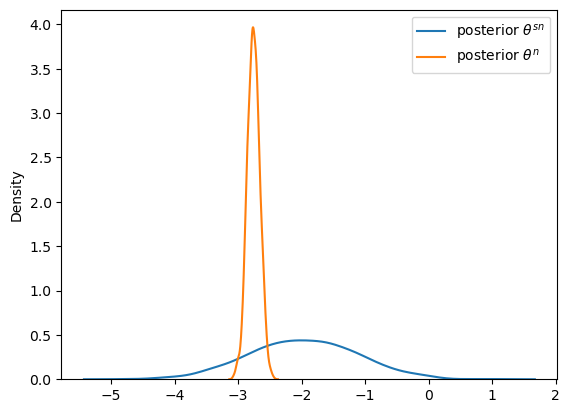

In [99]:
ax = sns.kdeplot(post_theta_s, label='posterior $\\theta^{sn}$')
sns.kdeplot(post_theta, ax=ax, label='posterior $\\theta^n$')
ax.legend()

In [14]:
path_run = Path('runs') / 'inference_30_S384_GS_SharedGamma'

inference_module = import_module(
    subjects_list=subjects_list,
    num_iter=42,
    load_state=path_run / 'checkpoints' / '2_state.pt',
    return_inference_module=True,
    device=DEVICE
)

/home/mind/alebris/storage/miniconda/envs/pavi_project/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [15]:
trace_model, trace_guide = inference_module.elbo._get_trace(
    inference_module.model,
    inference_module.guide,
    args=(),
    kwargs={
        'data': data,
        'idx': idx
    }
)

/home/mind/alebris/storage/miniconda/envs/pavi_project/lib/python3.10/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'l_s'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


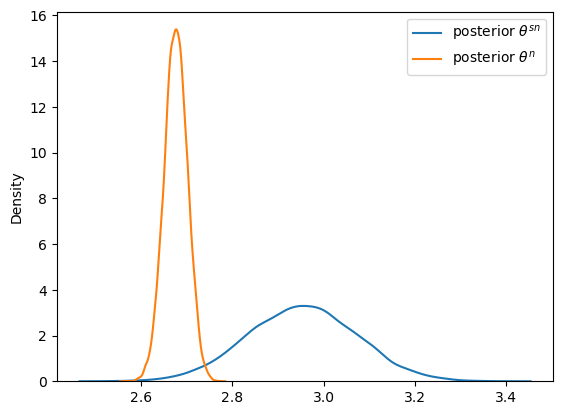

In [16]:
post_theta_s = np.random.normal(
    loc=trace_guide.nodes['theta_s']['fn'].transforms[0].loc[subject, voxel, network].detach(),
    scale=trace_guide.nodes['theta_s']['fn'].transforms[0].scale[subject, voxel, network].detach(),
    size=10000
)

post_theta = np.random.normal(
    loc=trace_guide.nodes['theta']['fn'].transforms[0].loc[voxel, network].detach(),
    scale=trace_guide.nodes['theta']['fn'].transforms[0].scale[voxel, network].detach(),
    size=10000
)

ax = sns.kdeplot(post_theta_s, label='posterior $\\theta^{sn}$')
sns.kdeplot(post_theta, ax=ax, label='posterior $\\theta^n$')
ax.legend()

In [17]:
path_run = Path('runs') / 'inference_30_S384_GS_SharedGamma_relax'

inference_module = import_module(
    subjects_list=subjects_list,
    num_iter=42,
    load_state=path_run / 'checkpoints' / '2_state.pt',
    return_inference_module=True,
    device=DEVICE
)

/home/mind/alebris/storage/miniconda/envs/pavi_project/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [18]:
trace_model, trace_guide = inference_module.elbo._get_trace(
    inference_module.model,
    inference_module.guide,
    args=(),
    kwargs={
        'data': data,
        'idx': idx
    }
)

/home/mind/alebris/storage/miniconda/envs/pavi_project/lib/python3.10/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'l_s'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


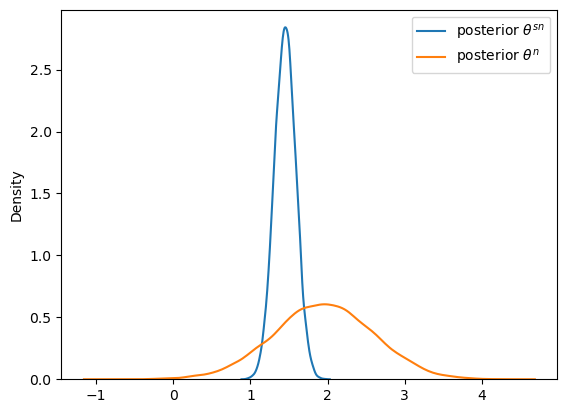

In [13]:
post_theta_s = np.random.normal(
    loc=trace_guide.nodes['theta_s']['fn'].transforms[0].loc[subject, voxel, network].detach(),
    scale=trace_guide.nodes['theta_s']['fn'].transforms[0].scale[subject, voxel, network].detach(),
    size=10000
)

post_theta = np.random.normal(
    loc=trace_guide.nodes['theta']['fn'].transforms[0].loc[voxel, network].detach(),
    scale=trace_guide.nodes['theta']['fn'].transforms[0].scale[voxel, network].detach(),
    size=10000
)

ax = sns.kdeplot(post_theta_s, label='posterior $\\theta^{sn}$')
sns.kdeplot(post_theta, ax=ax, label='posterior $\\theta^n$')
ax.legend()

In [28]:
trace_guide.nodes['theta_s']['fn'].transforms[0].scale.mean(0)

tensor([[0.3070, 0.2596, 0.2340,  ..., 0.1317, 0.3196, 0.3297],
        [0.2543, 0.2692, 0.2103,  ..., 0.4640, 0.6150, 0.2147],
        [0.3925, 0.1500, 0.1453,  ..., 0.2903, 0.6977, 0.2575],
        ...,
        [0.2682, 0.2757, 0.2622,  ..., 0.5500, 0.6828, 0.1890],
        [0.5515, 0.3819, 0.1428,  ..., 0.5594, 0.6521, 0.1854],
        [0.1069, 0.4742, 0.3740,  ..., 0.4137, 0.1458, 0.4101]],
       grad_fn=<MeanBackward1>)

In [21]:
trace_guide.nodes['gamma']['value']

tensor([0.6277, 0.5767, 0.5980, 0.5595, 0.4984, 0.5730, 0.6734, 0.5854, 0.5321,
        0.6591, 0.6064, 0.5404, 0.4394, 0.5142, 0.6357, 0.8523, 0.5206],
       grad_fn=<AddBackward0>)

In [25]:
trace_guide.nodes['theta']['fn'].transforms[0].scale

tensor([[0.6502, 0.5557, 0.5329,  ..., 0.6500, 0.8485, 0.5101],
        [0.6502, 0.5557, 0.5329,  ..., 0.6500, 0.8485, 0.5101],
        [0.6502, 0.5557, 0.5329,  ..., 0.6500, 0.8485, 0.5101],
        ...,
        [0.6502, 0.5557, 0.5329,  ..., 0.6500, 0.8485, 0.5101],
        [0.6502, 0.5557, 0.5329,  ..., 0.6500, 0.8485, 0.5101],
        [0.6502, 0.5557, 0.5329,  ..., 0.6500, 0.8485, 0.5101]],
       grad_fn=<ExpBackward0>)

In [96]:
trace_guide.nodes['mu_s']['fn'].transforms[1].scale

tensor([[[0.0013, 0.0014, 0.0010,  ..., 0.0010, 0.0010, 0.0010]],

        [[0.0013, 0.0012, 0.0011,  ..., 0.0011, 0.0010, 0.0009]],

        [[0.0017, 0.0019, 0.0013,  ..., 0.0016, 0.0014, 0.0012]],

        ...,

        [[0.0014, 0.0014, 0.0012,  ..., 0.0016, 0.0014, 0.0012]],

        [[0.0014, 0.0014, 0.0012,  ..., 0.0016, 0.0016, 0.0014]],

        [[0.0010, 0.0009, 0.0008,  ..., 0.0015, 0.0014, 0.0012]]],
       grad_fn=<ExpBackward0>)

In [103]:
trace_model.nodes['theta']['value'][0]

KeyError: 'theta'

In [104]:
trace_model.nodes['gamma']['value'][0]

KeyError: 'gamma'

In [91]:
trace_guide.nodes['theta_s']['value'].mean(0)

tensor([[ 1.4533, -0.7001, -0.0599,  ..., -0.3124, -0.6714,  0.0904],
        [ 0.2143,  1.1045,  2.0397,  ..., -1.4964, -1.7754,  0.5017],
        [-0.4605, -0.1503,  0.2030,  ...,  2.9121, -0.3714,  0.0232],
        ...,
        [ 2.1442,  0.1065, -0.3728,  ..., -0.7521, -1.3006, -0.1796],
        [-0.0230, -0.0609,  0.9566,  ..., -1.9358, -1.3882,  2.2825],
        [-0.4272, -0.2003, -0.9568,  ...,  1.0714,  1.9483, -0.6923]],
       grad_fn=<MeanBackward1>)

In [92]:
trace_guide.nodes['theta']['value']

tensor([[ 1.2917, -0.7709, -0.0744,  ..., -0.4575, -0.5600,  0.0690],
        [ 0.2144,  1.1754,  2.0014,  ..., -1.6093, -1.5995,  0.4186],
        [-0.3972, -0.2288,  0.2061,  ...,  2.8943, -0.3888,  0.0570],
        ...,
        [ 2.0644,  0.1279, -0.4117,  ..., -0.9643, -1.1802, -0.2563],
        [-0.1546, -0.2072,  0.9763,  ..., -1.7426, -1.5367,  2.1299],
        [-0.3219, -0.3180, -0.8481,  ...,  0.7847,  1.8419, -0.5947]],
       grad_fn=<AddBackward0>)

In [93]:
trace_guide.nodes['theta_s']['value'].std(0)

tensor([[0.5783, 0.6634, 0.6526,  ..., 0.6861, 0.7281, 0.6386],
        [0.6340, 0.6234, 0.4413,  ..., 1.0369, 0.8157, 0.5937],
        [0.6387, 0.6582, 0.6463,  ..., 0.4611, 0.6160, 0.6452],
        ...,
        [0.4722, 0.6418, 0.6723,  ..., 0.8431, 0.7735, 0.6838],
        [0.5433, 0.9789, 0.5661,  ..., 0.9382, 0.9009, 0.5131],
        [0.6804, 0.8150, 0.7866,  ..., 0.6577, 0.7111, 0.8336]],
       grad_fn=<StdBackward0>)

In [105]:
trace_guide.nodes['theta_s']['value'].std(0)

tensor([[2.9539, 2.9973, 2.4630,  ..., 2.6668, 3.0336, 3.0709],
        [2.2675, 2.7956, 2.7740,  ..., 2.5225, 2.4262, 2.5541],
        [3.0626, 2.7657, 2.9141,  ..., 2.6127, 2.7999, 2.5401],
        ...,
        [2.6462, 2.4280, 2.7880,  ..., 2.7305, 2.4913, 2.6881],
        [2.4166, 2.4505, 2.5343,  ..., 2.7244, 2.5016, 2.5913],
        [2.4775, 2.4770, 2.8908,  ..., 2.6141, 2.8081, 2.7877]],
       grad_fn=<StdBackward0>)

In [94]:
trace_guide.nodes['gamma']['value']

tensor([[0.5743, 0.7708, 0.6248,  ..., 0.7078, 0.7426, 0.5985],
        [0.6264, 0.6166, 0.4834,  ..., 0.9422, 0.8808, 0.6136],
        [0.6692, 0.7004, 0.6313,  ..., 0.4368, 0.7121, 0.5991],
        ...,
        [0.5202, 0.7406, 0.6548,  ..., 0.7800, 0.7949, 0.6160],
        [0.6960, 0.9102, 0.5131,  ..., 0.9530, 0.9980, 0.5517],
        [0.7432, 0.6925, 0.8733,  ..., 0.6476, 0.6049, 0.7637]],
       grad_fn=<AddBackward0>)

In [107]:
torch.diag(trace_guide.nodes['theta_s']['fn'].transforms[0].scale_tril[0,0])

tensor([2.7006, 2.7113, 2.7185, 2.7374, 2.7458, 2.7382, 2.6892, 2.1252, 2.6972,
        2.7154, 2.7444, 2.7084, 2.7116, 2.7011, 2.7109, 2.7014, 2.6902],
       grad_fn=<DiagonalBackward0_copy>)

In [56]:
torch.diag(trace_guide.nodes['theta_s']['fn'].transforms[0].scale_tril[0,0])

tensor([0.5466, 0.7369, 0.6257, 0.7317, 0.7673, 0.7875, 0.6448, 0.5247, 0.7873,
        0.7763, 0.7656, 0.4530, 0.5280, 0.7946, 0.7083, 0.7371, 0.6063],
       grad_fn=<DiagonalBackward0_copy>)

In [73]:
trace_guide.nodes['theta_s']['fn'].transforms[0].scale_tril.shape

torch.Size([64, 128, 17, 17])

In [76]:
trace_guide.nodes['theta_s']['fn'].transforms[0].loc[:, 100]

tensor([[-0.8209,  1.0289, -0.3345,  ..., -2.0542,  0.0837, -0.2915],
        [-0.8267,  1.0353, -0.3334,  ..., -2.0621,  0.0946, -0.2883],
        [-0.8494,  1.0071, -0.3470,  ..., -2.0430,  0.0972, -0.2931],
        ...,
        [-0.8366,  1.0571, -0.3354,  ..., -2.0687,  0.0919, -0.3017],
        [-0.8419,  1.0513, -0.3473,  ..., -2.0471,  0.0870, -0.2966],
        [-0.8144,  1.0371, -0.3384,  ..., -2.0319,  0.0715, -0.2863]],
       grad_fn=<SelectBackward0>)

In [53]:
(trace_guide.nodes['theta_s']['log_prob'] - trace_model.nodes['theta_s']['log_prob']).mean()

tensor(318.6573, grad_fn=<MeanBackward0>)

# Test model

In [14]:
from model import ModelGS as Model
import pyro
import pyro.poutine as poutine
from pyro.infer import TraceEnum_ELBO, config_enumerate

In [16]:


model = Model(
    num_labels=17,
    num_difumo_components=128,
    num_subjects=16,
    num_vertices=5_412,
    # num_sessions=2,
    device=torch.device('cpu')
)

idx_val = {
    'plate_S': torch.arange(16),
    'plate_N': torch.arange(2048),
    'plate_T': torch.arange(2)
}

elbo = TraceEnum_ELBO(max_plate_nesting=3)

with pyro.plate('sample', size=8, dim=-4):
    foo = config_enumerate(model)(idx=idx_val, device=torch.device('cpu'))
    
    trace_model = poutine.trace(model).get_trace(data=foo, idx=idx_val, device=torch.device('cpu'))
    trace_model.compute_log_prob()
    trace_model.compute_score_parts()
    model.render_model(data=foo, idx=idx_val)
    

Model - without enumerate Trace Shapes:                      
 Param Sites:                      
Sample Sites:                      
 plate_S dist             |        
        value          16 |        
     log_prob             |        
 plate_N dist             |        
        value        2048 |        
     log_prob             |        
    mu_g dist 8 1  1    1 |  17 128
        value 8 1  1    1 |  17 128
     log_prob 8 1  1    1 |        
 epsilon dist 8 1  1    1 |  17 128
        value 8 1  1    1 |  17 128
     log_prob 8 1  1    1 |        
    mu_s dist 8 1 16    1 |  17 128
        value 8 1 16    1 |  17 128
     log_prob 8 1 16    1 |        
   gamma dist 8 1  1    1 |  17    
        value 8 1  1    1 |  17    
     log_prob 8 1  1    1 |        
   kappa dist 8 1  1    1 |   1    
        value 8 1  1    1 |   1    
     log_prob 8 1  1    1 |        
   theta dist 8 1  1 2048 |  17    
        value 8 1  1 2048 |  17    
     log_prob 8 1  1 2048 |        
 t

In [13]:
trace_model.nodes['l_s']['value'].shape

torch.Size([8, 16, 2048, 1])